# Set Up

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

In [2]:
tf.__version__

'2.15.0'

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Extra

# Data Collection/Preprocessing

## Collecting Data

In [4]:
data = pd.read_csv("../outputs/training_metadata.csv")

In [5]:
data.head()

,path,left,right,forward,backward,brake
0,outputs/training_data/10.jpeg,0,0,1,0,0
1,outputs/training_data/11.jpeg,0,0,1,0,0
2,outputs/training_data/12.jpeg,0,0,1,0,0
3,outputs/training_data/13.jpeg,0,0,1,0,0
4,outputs/training_data/14.jpeg,0,0,1,0,0


## Analyzing Data

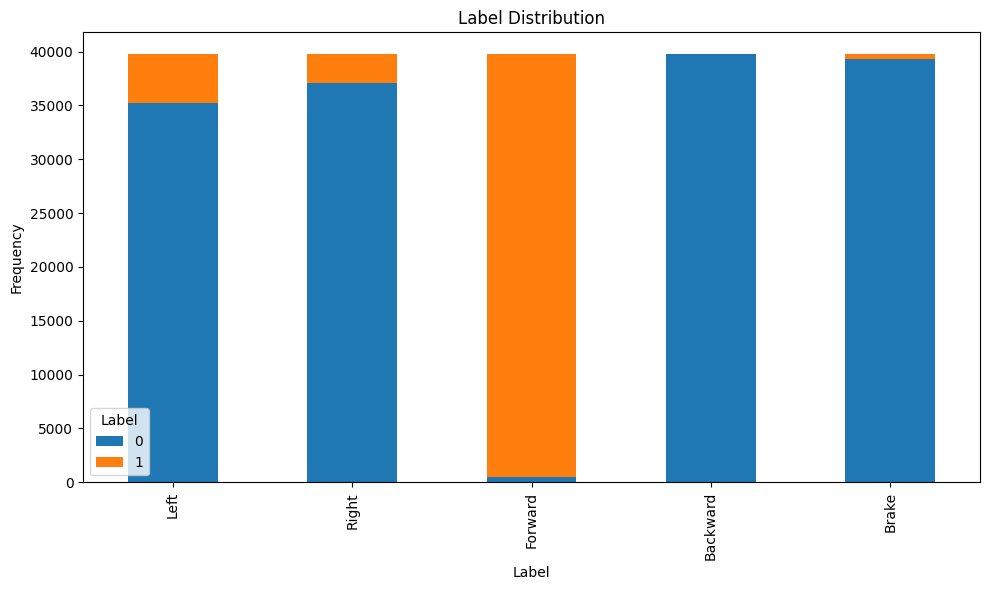

In [6]:
left_labels = data['left']
right_labels = data['right']
forward_labels = data['forward']
backward_labels = data['backward']
brake_labels = data['brake']

left_counts = left_labels.value_counts()
right_counts = right_labels.value_counts()
forward_counts = forward_labels.value_counts()
backward_counts = backward_labels.value_counts()
brake_counts = brake_labels.value_counts()

df = pd.DataFrame({
    'Left': left_counts,
    'Right': right_counts,
    'Forward': forward_counts,
    'Backward': backward_counts,
    'Brake': brake_counts
}).transpose()

# Plot the distribution of labels
fig, ax = plt.subplots(figsize=(10, 6))

df.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Label Distribution')
ax.set_xlabel('Label')
ax.set_ylabel('Frequency')
ax.legend(['0', '1'], title='Label')

plt.tight_layout()
plt.show()

## Preprocessing Data

In [7]:
def load_image(image_path):
    image = Image.open("../"+image_path)
    image = np.array(image)
    return image

In [8]:
data['path'][0]

'outputs/training_data/10.jpeg'

In [9]:
images = [load_image(image_path) for image_path in data['path']]
images = np.array(images)

In [10]:
images[0].shape

(64, 64)

In [11]:
# mean = np.mean(images, axis=(0, 1, 2))
# std = np.std(images, axis=(0, 1, 2))
# scaled_images = (images - mean) / std

In [12]:
targets = data[['left', 'right', 'forward', 'brake']].values

## Splitting Data

In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(
    images, targets, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

In [14]:
len(X_train)

31832

In [15]:
len(X_test)

3979

# Neural Network

## Model Set Up

In [16]:
optimizer = Adam(learning_rate=0.001)

In [17]:
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(
        64, 64, 1)),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(40, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(4, activation='sigmoid')
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 31, 31, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                        

## Training Model

In [19]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])

In [20]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
995/995 [==============================] - 99s 99ms/step - loss: 0.1101 - binary_accuracy: 0.9595 - val_loss: 0.0337 - val_binary_accuracy: 0.9884
Epoch 2/10
995/995 [==============================] - 89s 89ms/step - loss: 0.0344 - binary_accuracy: 0.9880 - val_loss: 0.0162 - val_binary_accuracy: 0.9942
Epoch 3/10
995/995 [==============================] - 99s 100ms/step - loss: 0.0187 - binary_accuracy: 0.9939 - val_loss: 0.0152 - val_binary_accuracy: 0.9957
Epoch 4/10
995/995 [==============================] - 93s 93ms/step - loss: 0.0151 - binary_accuracy: 0.9954 - val_loss: 0.0049 - val_binary_accuracy: 0.9979
Epoch 5/10
995/995 [==============================] - 90s 91ms/step - loss: 0.0103 - binary_accuracy: 0.9970 - val_loss: 0.0053 - val_binary_accuracy: 0.9985
Epoch 6/10
995/995 [==============================] - 93s 94ms/step - loss: 0.0090 - binary_accuracy: 0.9975 - val_loss: 0.0027 - val_binary_accuracy: 0.9991
Epoch 7/10
995/995 [==============================]

## Testing Model

In [21]:
test_loss = model.evaluate(X_test, y_test)

125/125 [==============================] - 3s 27ms/step - loss: 0.0025 - binary_accuracy: 0.9990


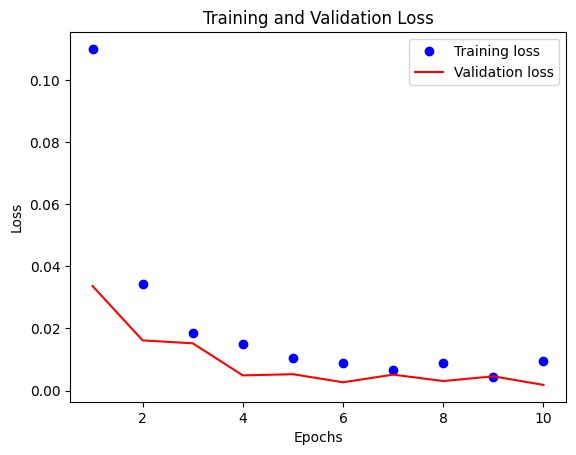

In [22]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

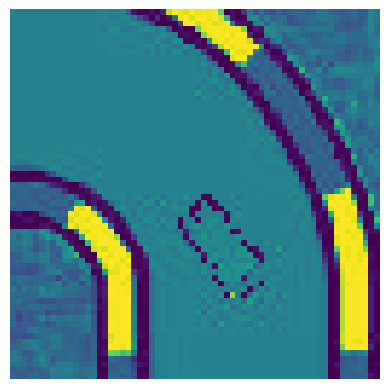

In [36]:
image = X_test[8]
plt.imshow(image)
plt.axis('off')
plt.show()

In [37]:
test_image = image.reshape(1, 64, 64, 1)
predictions = model.predict(test_image)
print(predictions)

1/1 [==============================] - 0s 21ms/step
[[1.2930645e-08 9.8726350e-01 1.0000000e+00 3.3917485e-12]]


## Prediction Distribution

In [25]:
predictions_list = []
for num in range(250):
    image = X_test[num]
    test_image = image.reshape(1, 64, 64, 1)
    prediction = model.predict(test_image)
    predictions_list.append(prediction)

1/1 [==============================] - 0s 11ms/step


In [26]:
predictions_list

[array([[1.0586107e-11, 9.4093417e-15, 1.0000000e+00, 3.0064209e-22]],
       dtype=float32),
 array([[1.7198980e-11, 1.9917031e-14, 1.0000000e+00, 1.8976598e-22]],
       dtype=float32),
 array([[6.8066774e-11, 4.6390766e-15, 1.0000000e+00, 4.1184410e-21]],
       dtype=float32),
 array([[2.0790228e-10, 6.8070279e-11, 1.0000000e+00, 1.2396101e-17]],
       dtype=float32),
 array([[9.9996400e-01, 5.1102685e-12, 1.0000000e+00, 1.8100142e-14]],
       dtype=float32),
 array([[5.4349517e-14, 5.6544305e-18, 1.0000000e+00, 1.5354142e-27]],
       dtype=float32),
 array([[1.9423296e-13, 8.5183848e-12, 1.0000000e+00, 1.3916019e-23]],
       dtype=float32),
 array([[2.3874014e-10, 1.8978072e-06, 1.0000000e+00, 1.5268492e-15]],
       dtype=float32),
 array([[1.2930645e-08, 9.8726350e-01, 1.0000000e+00, 3.3917485e-12]],
       dtype=float32),
 array([[6.9874308e-11, 1.0221293e-09, 1.0000000e+00, 8.9004789e-20]],
       dtype=float32),
 array([[2.0606641e-11, 1.1361422e-10, 1.0000000e+00, 4.6139

In [27]:
# intermediate_layer_model = tf.keras.Model(inputs=model.input,
#                                                outputs=model.get_layer('conv2d_4').output)
# activations = intermediate_layer_model.predict(test_image.reshape(1, 64, 64, 1))

# print(activations.shape[-1])

# plt.figure(figsize=(10, 10))
# for i in range(activations.shape[-1]):
#     plt.subplot(8, 8, i+1)
#     plt.imshow(activations[0, :, :, i], cmap='viridis')
#     plt.axis('off')
# plt.show()

## Saving Model Weights

In [28]:
model.save("../models/CNN/CNN_steering_model_manual_gs_CMBx4_10epoch_sig_bc.h5")

/Users/andrew/Desktop/Projects/SelfDrivingCarSimulator/env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
